### Warning
This is a long post. It wasn't meant to be this way, but reaction diffusion equations proved to be too damn interesting not to write a lot about. To try and understand the system, I do some maths and some programming. Be warned, the maths isn't rigorous and the code isn't the most efficient. This is a deliberate choice. My goal is to try and understand the system, and along the way learn to create images like this

![title](http://www.degeneratestate.org/static/turing-patterns/title.png)


# Turing Patterns

In 1952, [Turing](https://en.wikipedia.org/wiki/Alan_Turing) published a paper called ["The Chemical Basis of Morphogenesis"](http://www.dna.caltech.edu/courses/cs191/paperscs191/turing.pdf) suggesting a possible mechanism for how a simple set of chemical reactions could lead to the formation of stripes, spots and other patterns we see on animals. It is a surprisingly readable paper that covers some maths, some chemistry, some numerical modelling and ties it all together to try and answer a biological question. 

At the core of the paper are a set of partial differential equations known as [reaction-diffusion equations](https://en.wikipedia.org/wiki/Reaction%E2%80%93diffusion_system). Turing's analysis shows that in certain regimes systems that obey these equations are unstable to small perturbations, leading to the growth of large scale patterns.

If you have only a basic understanding of chemistry (like I do) this might be surprising. Most chemical reactions I've seen involve homogeneous concentrations of reagents, reacting to create the final products, often described by a reaction equation like

$A + B \rightarrow C + D$

In this simplified model there is no room for pattern formation, because haven't included any description about how concentrations of the different chemicals vary in space. Once we take into account these differences, a much richer set of behaviours is possible.

In this post, I am going explore the system described in the paper.


## Reaction Diffusion Equations

Reaction-Diffusion equations are a class of partial differential equations whose dynamics are governed by two terms: a diffusion part and a reaction part. We will be looking at the two component case, which takes the form

$\frac{\partial a(x,t)}{\partial t} = D_{a}\frac{\partial^{2} a(x,t)}{\partial x^{2}} + R_{a}(a(x,t),b(x,t))$

$\frac{\partial b(x,t)}{\partial t} = D_{b}\frac{\partial^{2} b(x,t)}{\partial x^{2}} + R_{b}(a(x,t),b(x,t))$

Where the $a(x,t)$ and $b(x,t)$ describe the concentration of chemicals $a$ and $b$ at position $x$ and time $t$. The functions $R_{a}$ and $R_{b}$ determine how the concentrations change due to interspecies reactions and $D_{a}$ and $D_{b}$ are the diffusion coefficients. 

### Diffusion

The diffusion part of the equations causes areas of high concentration to spread out to areas of low concentration, while conserving the total amount of the chemical. To get a feel for what's happening, let's focus the equation

$ \frac{\partial a(x,t)}{\partial t} = D_{a}\frac{\partial^{2} a(x,t)}{\partial x^{2}} $

If this looks familiar, it is because it appears in a number of different areas of science and maths. A few are: the [diffusion equation](https://en.wikipedia.org/wiki/Diffusion_equation), the [heat equation](https://en.wikipedia.org/wiki/Heat_equation) and [Brownian motion](https://en.wikipedia.org/wiki/Brownian_motion). 

It has an analytic solution, which for initial Gaussian distribution is

$ a(x,t) = \frac{a_{0}}{\sqrt{2\pi(\sigma_{0}^{2} + 2 D_{a} t)}} \exp\left(-\frac{x^{2}}{2(\sigma_{0}^{2} +  2 D_{a} t)}\right)$

A "spreading out", or diffusion over time, as the name suggests.

### Simulating equations

If you've got this far, you might have noticed that this is written in a [jupyter notebook](http://jupyter.org/). This allows us to mix code with writing, so we don't just have to look at an equation to understand how it behaves - we can simulate it directly. 

To simulate the PDEs, I'm going to use the [explicit finite-difference method](https://en.wikipedia.org/wiki/Finite_difference_method#Example:_The_heat_equation). It is not the best numerical method to use, but it is easy to code, and provided we keep the time step small enough it will be stable. 

Under this scheme, we approximate the time derivative as

$$
\frac{\partial a(x,t)}{\partial t} \approx \frac{1}{dt}(a_{x,t+1} - a_{x,t})
$$

And the spatial part of the derivative (which is usually know as the [Laplacian](https://en.wikipedia.org/wiki/Laplace_operator)) as

$$
\frac{\partial^{2} a(x,t)}{\partial x^{2}} \approx \frac{1}{dx^{2}}(a_{x+1,t} + a_{x-1,t} - 2a_{x,t})
$$

Putting it all together, for the diffusion part of the equation we get.

$$
a_{x,t+1} = a_{x,t} + dt\left(  \frac{D_{a}}{dx^{2}}(a_{x+1,t} + a_{x-1,t} - 2a_{x,t})  \right)
$$

Let's start by defining some functions to take care of the spatial derivatives. We will be using periodic boundary conditions throughout our exploration, which are easy to implement in numpy using its [roll](https://docs.scipy.org/doc/numpy-1.12.0/reference/generated/numpy.roll.html) function.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

# I'm using seaborn for it's fantastic default styles
import seaborn as sns
sns.set_style("whitegrid")

%matplotlib inline
%load_ext autoreload
%autoreload 2

from tutils import BaseStateSystem

In [2]:
def laplacian1D(a, dx):
    return (
        - 2 * a
        + np.roll(a,1,axis=0) 
        + np.roll(a,-1,axis=0)
    ) / (dx ** 2)

def laplacian2D(a, dx):
    return (
        - 4 * a
        + np.roll(a,1,axis=0) 
        + np.roll(a,-1,axis=0)
        + np.roll(a,+1,axis=1)
        + np.roll(a,-1,axis=1)
    ) / (dx ** 2)

To aid in generating visualisations, I've written a base class which updates and plots a system based on some notion of state. There's nothing specific about the reaction diffusion equations encoded in it, so I'm not going to go into any detail about it. You can find the full code for it, along with this notebook on github [here](https://github.com/ijmbarr/turing-patterns). It uses [matplotlib's animation](http://matplotlib.org/api/animation_api.html) functionality to plot the output as a gif.

All together we can simulate the effect of the diffusion equation:

In [3]:
class OneDimensionalDiffusionEquation(BaseStateSystem):
    def __init__(self, D):
        self.D = D
        self.width = 1000
        self.dx = 10 / self.width
        self.dt = 0.9 * (self.dx ** 2) / (2 * D)
        self.steps = int(0.1 / self.dt)
        
        
    def initialise(self):
        self.t = 0
        self.X = np.linspace(-5,5,self.width)
        self.a = np.exp(-self.X**2)
        
    def update(self):
        for _ in range(self.steps):
            self.t += self.dt
            self._update()

    def _update(self):      
        La = laplacian1D(self.a, self.dx)
        delta_a = self.dt * (self.D * La)       
        self.a += delta_a
        
    def draw(self, ax):
        ax.clear()
        ax.plot(self.X,self.a, color="r")
        ax.set_ylim(0,1)
        ax.set_xlim(-5,5)
        ax.set_title("t = {:.2f}".format(self.t))
    
one_d_diffusion = OneDimensionalDiffusionEquation(D=1)

In [4]:
one_d_diffusion.plot_time_evolution("diffusion.html")
HTML("diffusion.html")



As expected - the diffusion equation causes the the concentration to "spread out".

### Reaction

Interactions between the two chemical components are introduced via the functions $R_{a}$ and $R_{b}$. These functions only depend on the local concentration of each of the chemicals. Their exact form will depend on the chemicals involved, but it is possible to show that Turing patterns are observed for a whole class of different equations.

The one thing we will require from these equations is that they reach a stable equilibrium when the concentrations of the chemicals involved are completely homogeneous. This means that there exists concentrations of $a$ and $b$ such that

$R_a(a_{0}, b_{0}) = 0$

$R_{b}(a_{0}, b_{0}) = 0$

The fact that we require this to hold will make the later instability more suprising.

For the reaction equations, I'm going to use the [FitzHugh–Nagumo equation](https://en.wikipedia.org/wiki/FitzHugh%E2%80%93Nagumo_model)

$R_a(a, b) = a - a^{3} - b + \alpha$

$R_{b}(a, b) = \beta (a - b)$

Where $\alpha$ and $\beta$ are constants.

Let's see how it behaves

In [22]:
class ReactionEquation(BaseStateSystem):
    def __init__(self, Ra, Rb):
        self.Ra = Ra
        self.Rb = Rb
        self.dt = 0.01
        self.steps = int(0.1 / self.dt)
        
    def initialise(self):
        self.t = 0
        self.a = 0.1
        self.b = 0.7
        self.Ya = []
        self.Yb = []
        self.X = []
        
    def update(self):
        for _ in range(self.steps):
            self.t += self.dt
            self._update()

    def _update(self):      
        delta_a = self.dt * self.Ra(self.a,self.b)      
        delta_b = self.dt * self.Rb(self.a,self.b)      

        self.a += delta_a
        self.b += delta_b
        
    def draw(self, ax):
        ax.clear()
        
        self.X.append(self.t)
        self.Ya.append(self.a)
        self.Yb.append(self.b)

        ax.plot(self.X,self.Ya, color="r", label="A")
        ax.plot(self.X,self.Yb, color="b", label="B")
        ax.legend()
        
        ax.set_ylim(0,1)
        ax.set_xlim(0,5)
        ax.set_xlabel("t")
        ax.set_ylabel("Concentrations")
        
alpha, beta =  0.2, 5

def Ra(a,b): return a - a ** 3 - b + alpha
def Rb(a,b): return (a - b) * beta
    
one_d_reaction = ReactionEquation(Ra, Rb)


In [23]:
one_d_reaction.plot_time_evolution("reaction.html",n_steps=50)
HTML("reaction.html")

The system is stable, and stabilises to $a = b = \sqrt[3]{\alpha}$.

## Full Model

We now have two parts to the reaction diffusion equation: a diffusion term that "spreads" out concentration and a reaction part the equalises the two concentrations. It feels like these two together should create a stable system, so it is surprising that we can end up with patterns.

But enough with the preliminaries, let's take a look at some of the patterns formed. 

In [7]:
def random_initialiser(shape):
    return(
        np.random.normal(loc=0, scale=0.05, size=shape),
        np.random.normal(loc=0, scale=0.05, size=shape)
    )

class OneDimensionalRDEquations(BaseStateSystem):
    def __init__(self, Da, Db, Ra, Rb,
                 initialiser=random_initialiser,
                 width=1000, dx=1, 
                 dt=0.1, steps=1):
        
        self.Da = Da
        self.Db = Db
        self.Ra = Ra
        self.Rb = Rb
        
        self.initialiser = initialiser
        self.width = width
        self.dx = dx
        self.dt = dt
        self.steps = steps
        
    def initialise(self):
        self.t = 0
        self.a, self.b = self.initialiser(self.width)
        
    def update(self):
        for _ in range(self.steps):
            self.t += self.dt
            self._update()

    def _update(self):
        
        # unpack so we don't have to keep writing "self"
        a,b,Da,Db,Ra,Rb,dt,dx = (
            self.a, self.b,
            self.Da, self.Db,
            self.Ra, self.Rb,
            self.dt, self.dx
        )
        
        La = laplacian1D(a, dx)
        Lb = laplacian1D(b, dx)
        
        delta_a = dt * (Da * La + Ra(a,b))
        delta_b = dt * (Db * Lb + Rb(a,b))
        
        self.a += delta_a
        self.b += delta_b
        
    def draw(self, ax):
        ax.clear()
        ax.plot(self.a, color="r", label="A")
        ax.plot(self.b, color="b", label="B")
        ax.legend()
        ax.set_ylim(-1,1)
        ax.set_title("t = {:.2f}".format(self.t))
        
Da, Db, alpha, beta = 1, 100, -0.005, 10

def Ra(a,b): return a - a ** 3 - b + alpha
def Rb(a,b): return (a - b) * beta

width = 100
dx = 1
dt = 0.001

OneDimensionalRDEquations(
    Da, Db, Ra, Rb, 
    width=width, dx=dx, dt=dt, 
    steps=100
).plot_time_evolution("1dRD.html", n_steps=150)
HTML("1dRD.html")

A pattern of stripes.

We can see that same behavior in two dimensions:

In [8]:
class TwoDimensionalRDEquations(BaseStateSystem):
    def __init__(self, Da, Db, Ra, Rb,
                 initialiser=random_initialiser,
                 width=1000, height=1000,
                 dx=1, dt=0.1, steps=1):
        
        self.Da = Da
        self.Db = Db
        self.Ra = Ra
        self.Rb = Rb

        self.initialiser = initialiser
        self.width = width
        self.height = height
        self.shape = (width, height)
        self.dx = dx
        self.dt = dt
        self.steps = steps
        
    def initialise(self):
        self.t = 0
        self.a, self.b = self.initialiser(self.shape)
        
    def update(self):
        for _ in range(self.steps):
            self.t += self.dt
            self._update()

    def _update(self):
        
        # unpack so we don't have to keep writing "self"
        a,b,Da,Db,Ra,Rb,dt,dx = (
            self.a, self.b,
            self.Da, self.Db,
            self.Ra, self.Rb,
            self.dt, self.dx
        )
        
        La = laplacian2D(a, dx)
        Lb = laplacian2D(b, dx)
        
        delta_a = dt * (Da * La + Ra(a,b))
        delta_b = dt * (Db * Lb + Rb(a,b))
        
        self.a += delta_a
        self.b += delta_b
        
    def draw(self, ax):
        ax[0].clear()
        ax[1].clear()

        ax[0].imshow(self.a, cmap='jet')
        ax[1].imshow(self.b, cmap='brg')
        
        ax[0].grid(b=False)
        ax[1].grid(b=False)
        
        ax[0].set_title("A, t = {:.2f}".format(self.t))
        ax[1].set_title("B, t = {:.2f}".format(self.t))
        
    def initialise_figure(self):
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
        return fig, ax
    
Da, Db, alpha, beta = 1, 100, -0.005, 10

def Ra(a,b): return a - a ** 3 - b + alpha
def Rb(a,b): return (a - b) * beta

width = 100
dx = 1
dt = 0.001

TwoDimensionalRDEquations(
    Da, Db, Ra, Rb, 
    width=width, height=width, 
    dx=dx, dt=dt, steps=100
).plot_evolution_outcome("2dRD.png", n_steps=150)

[![reaction](http://www.degeneratestate.org/static/turing-patterns/2dRD.png)](http://www.degeneratestate.org/static/turing-patterns/2dRD.gif)

(It is possible to animate the formation of these patterns using a similar method call as in the one-dimensional case above. The resulting gifs are quite impressive, but also large, so they are not directly included here. However, if you click on the image it will take you to the animation)

It turns out this behaviour is common to a lot of reaction-diffusion equations, not just the ones presented here. 

So how does this happen? To understand, we are going to need to do some maths. 

## Stability Analysis

Let's return to the original equations. We've seen that for certain conditions, pattern formations occurs.

Unfortunately, solving the equations directly for non-linear reaction functions is often not possible. Instead we can look at what happens when the the system is perturbed slightly from equilibrium.

### Linearising the Equations

We start by assuming there is some concentrations, $a_{0}$ and $b_{0}$, for which the system is stable. This means that 
 - $R_{a}(a_{0},b_{0}) = 0$
 - $R_{b}(a_{0},b_{0}) = 0$
 
Around these solutions, we look at the time dependence of small perturbations around these values
 - $x = a - a_{0}$
 - $y = b - b_{0}$
 
And linearise the reaction equations
 - $R_{a}(a,b) \approx r_{aa}x + r_{ab}y$
 - $R_{b}(a,b) \approx r_{ba}x + r_{bb}y$
 
where $r_{ij} = \frac{\partial R_{i}}{\partial j}$.

These approximations give us a set of linear equations, written in vector form as

$\dot{\mathbf{x}} = D\nabla^{2} \mathbf{x} + R \mathbf{x}$

Where $R = \left(\begin{matrix} r_{11} & r_{12} \\ r_{21} & r_{22}\end{matrix}\right)$ and $D = \left(\begin{matrix} D_{a} & 0 \\ 0 & D_{b}\end{matrix}\right)$

### Fourier Transform
If we impose periodic boundary conditions to this equation, a natural solution can be found by applying a [Fourier Transformation](https://acko.net/files/gltalks/toolsforthought/) to $\mathbf{x}$. If we call the reciprocal coordinate $k$, and the Fourier transform of $\mathbf{x}$ as $\tilde{\mathbf{x}}$, then the transformed equation is 

$\dot{\tilde{\mathbf{x}}} = (R - k^{2}D) \tilde{\mathbf{x}}$

Which, has solutions of the form

$\tilde{\mathbf{x}}(t) = \tilde{\mathbf{x}}(0) e^{\omega t}$

To find $\omega$ we plug this solution back into our transformed equation to get

$\omega \tilde{\mathbf{x}} = (R - k^{2}D) \tilde{\mathbf{x}}$

Showing that $\omega$ is just the eigenvalue of $(R - k^{2}D)$. 

### Stability

We now have an equation for the time dependence of our system in the Fourier domain. Using it, we can now discuss what we mean by _stability_. Our system is considered stable if small perturbations around the homogeneous do not cause it to move further away from the stable solutions. 

In terms of our solution, $\tilde{\mathbf{x}}(0) e^{\omega t}$, stability means that the values of $\omega$ does not have positive real parts for all values of $k$. If $\omega$ is negative, the perturbation will decay away. If $\omega$ is imaginary, it will oscillate around the stable state. However, if it is positive and real _any_ small perturbation will grow exponentially, until a high order term of the reaction equation becomes important.

To find $\omega$, we need to solve the equation

$\hbox{Det}(R - k^{2}D - \omega I) = 0 $

Writing $J = R - k^{2}D$, this equitation takes the form

$\omega^{2} - \omega\hbox{Tr}(J) + \hbox{Det}(J) = 0$

Solving for $\omega$, we get

$\omega = \frac{1}{2}(\hbox{Tr}(J) \pm \sqrt{\hbox{Tr}(J)^{2} - 4 \hbox{Det}(J) })$

### Conditions for (in)Stability

From our initial assumption that there was a stable homogeneous state, we require that $\omega$ has negative real parts where $k = 0$, which corresponds to the spatially homogeneous solution. For this to be true, we require that 

 - $\hbox{Tr}(R) < 0$
 - $\hbox{det}(R) > 0$
 
Or, in terms of the components of $R$:
 - $r_{aa} + r_{bb} < 0$
 - $r_{aa}r_{bb} - r_{ab}r_{ba} > 0$

For an instability to now occur at finite wavelength, we need one of the following conditions to hold:
 - $\hbox{Tr}(J) > 0$
 - $\hbox{det}(J) < 0$

Because $\hbox{Tr}(J) = \hbox{Tr}(R) - k^{2}(d_{a} + d_{b})$, the first condition cannot hold for any real $k$. This means the we require the second to hold, or, after a bit of algebra

$k^{4}d_{a}d_{b} - k^{2}(d_{a}r_{bb} + d_{b}r_{aa}) + (r_{aa}r_{bb} - r_{ab}r_{ba}) < 0$

for some real value of $k$. Once again, we need to solve a quadratic equation. To do this we note that because $k$ needs to be real, $k^{2}$ must be positive. This means that at least one root of quadratic equation in $k^{2}$ needs to be positive and real. This condition is only met when 

$d_{b}r_{aa} + d_{a}r_{bb} > 2\sqrt{d_{a}d_{b}(r_{aa}r_{bb} - r_{ab}r_{ba})} > 0$

And that's it. We've derived that conditions for the diffusion-reaction equations to be stable to small perturbations. 

We can write the complete requirements as

1. $r_{aa} + r_{bb} < 0$
2. $r_{aa}r_{bb} - r_{ab}r_{ba} > 0$
3. $d_{b}r_{aa} + d_{a}r_{bb} > 2\sqrt{d_{a}d_{b}(r_{aa}r_{bb} - r_{ab}r_{ba})} > 0$

### Discussion
We've waded through a lot of maths to reach this point. Let's take stock of what we can make of the conditions for instability that we have derived. 

Given the diffusion coefficients are positive, from the first and third equation above, we know that $r_{aa}$ and $r_{bb}$ have to have different signs, and the component with the negative sign has to be larger. Combining this we the second equation we know that either $r_{ab}$ or $r_{ba}$ has to be negative, and the other has to be positive. This two facts show why some systems like this are called activator-inhibitor system: the presence of one component increase the production of itself - the other inhibits the production of both.

With this information, the third equation shows us that the diffusion coefficients need to be different. Specifically, the diffusion coefficient of the inhibitor has to be larger then that of the activator.

Together, this gives us a hand-waving explanation of what might be going on: Consider starting with a small increase in the activator at some point. This in turn creates an increase in the inhibitor at that point. Both of these chemical diffuse to nearby points, but the inhibitor diffuses faster, lowering the activator concentration of nearby points. This lowering of the activator concentration at nearby points, which in turn lowers the inhibitor concentration. The disturbance spreads out like a wave. 

It is a lot easier to get a feel for what's going on once we visualise the this perturbation:

In [ ]:
Da, Db, alpha, beta = 1, 100, -0.005, 10

def Ra(a,b): return a - a ** 3 - b + alpha
def Rb(a,b): return (a - b) * beta

def initalise_bump(shape):
    a  = np.zeros(shape)
    if len(a.shape) == 1:
        a[int(a.shape[0] / 2)] = 0.3
    elif len(a.shape) == 2:
        a[int(a.shape[0] / 2), int(a.shape[1] / 2)] = 0.3

    return(
        a,
        np.zeros(shape)
    )

width = 100
dx = 1
dt = 0.001

OneDimensionalRDEquations(
    Da, Db, Ra, Rb, 
    initialiser=initalise_bump, 
    width=width, dx=dx, dt=dt, 
    steps=250
).plot_time_evolution("1dRD_initial_bump.html", n_steps=150)

In [24]:
HTML("1dRD_initial_bump.html")

### Exploring the Parameter Space

It is interesting to ask how the parameters of the equations affect the pattern formation. To get a feel for what this dependence is, we can investigate the amplitude of the instability for different frequencies. Close to equilibrium, we expect the frequency with the largest real component to dominate the dynamics of the system.

Calculating this value isn't mathematically difficult: we have an equation of the amplitude $\omega$ in terms of the frequency $k$ above. Differentiating an equation of this size by hand can become tedious due to its size, and it is easy to introduce errors. And why carry out simple replacement steps when we have a computer to hand?

In the following, I use the computer algebra system [sympy](http://www.sympy.org/en/index.html) to find the largest real mode of the system

In [10]:
import sympy as sp


a,b,alpha,beta = sp.symbols("a,b,alpha,beta")
Raa, Rab, Rba, Rbb = sp.symbols("Raa, Rab, Rba, Rbb")
Da, Db = sp.symbols("Da, Db")
k2 = sp.Symbol("k2")
# create matricies
R = sp.Matrix(
    [[Raa, Rab],
     [Rba, Rbb]]
)

D = sp.Matrix(
    [[Da, 0],
     [0, Db]]
)

J = (R - k2 * D)
omega = sp.Matrix.trace(J) + sp.sqrt(sp.Matrix.trace(J) ** 2 - 4 * sp.Matrix.det(J))


In [11]:
omega

-Da*k2 - Db*k2 + Raa + Rbb + sqrt(4*Rab*Rba - 4*(-Da*k2 + Raa)*(-Db*k2 + Rbb) + (-Da*k2 - Db*k2 + Raa + Rbb)**2)

In [12]:
# find the maximum value of omega for k^{2}
omega_prime = sp.diff(omega, k2)
sols = sp.solvers.solve(omega_prime, k2)
max_k2 = sols[0]

max_k2

(Da*Db*Raa - Da*Db*Rbb - Da*sqrt(-Da*Db*Rab*Rba) - Db*sqrt(-Da*Db*Rab*Rba))/(Da*Db*(Da - Db))

In [13]:
def get_length_scale(al, be, da, db):

    # rewritng in terms of Da, Db, alpha, beta
    Ra = a - a**3 - b + alpha
    Rb = beta * (a - b)

    # we expand around the homogenius steady state
    zero_subs = [
        (a, sp.sign(alpha) * sp.cbrt(sp.Abs(alpha))),
        (b, sp.sign(alpha) * sp.cbrt(sp.Abs(alpha)))
    ]

    # and linearise
    R_prime_subs = {
        (Raa, sp.diff(Ra, a)),
        (Rab, sp.diff(Ra, b)),
        (Rba, sp.diff(Rb, a)),
        (Rbb, sp.diff(Rb, b))
    }

    # putting in our numeric values we get
    vals = [
        (alpha, al),
        (beta, be),
        (Da, da),
        (Db, db)
    ]

    # substitute it all in to find the maximum k
    max_k2 = [sp.N(
        sol
        .subs(R_prime_subs)
        .subs(zero_subs)
        .subs(vals)
    ) for sol in sols]
    
    k2 = max(sp.re(sym) for sym in max_k2)
    
    # if k2 is negative, no real solution exists
    if k2 <= 0:
        return -1
    
    # convert k2 into length units
    return sp.N(2 * sp.pi / sp.sqrt(k2))

get_length_scale(-0.005, 10, 1, 100)

13.6336345738685

Which looks about right when we compare it to our simulations above - the spatial variation is about 14 length units.

Let's use it to see how the length scale of the system changes as a function of $\alpha$ and $\beta$:

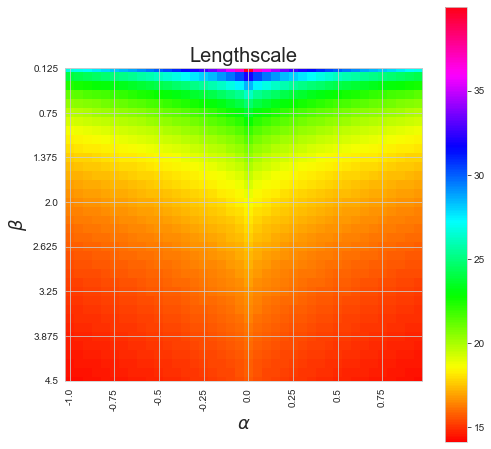

In [14]:
betas = [(1 + i) * 0.125 for i in range(0,40)]
alphas = [i * 0.05 for i in range(-20,20)]

outcomes = np.zeros((len(betas), len(alphas)))

for x,al in enumerate(alphas):
    for y,be in enumerate(betas):
        outcomes[y,x] = get_length_scale(al, be, 1, 100)


plt.figure(figsize=(8,8))

o = outcomes
o[outcomes == 0] = -1

plt.imshow(o, cmap="hsv", interpolation="none")
plt.colorbar()

plt.xticks(*zip(*[(n,l) for n,l in enumerate(alphas) if n % 5 == 0]), rotation=90)
plt.yticks(*zip(*[(n,l) for n,l in enumerate(betas) if n % 5 == 0]), rotation=0)

plt.title("Lengthscale", fontsize=20)
plt.xlabel(r"$\alpha$", fontsize=18)
plt.ylabel(r"$\beta$", fontsize=18);

And take a look at the long length scale we should see when we use a low value of $\beta$:

In [15]:
Da, Db, alpha, beta = 1, 100, 0.01, 0.25

def Ra(a,b): return a - a ** 3 - b + alpha
def Rb(a,b): return (a - b) * beta

width = 200
dx = 1
dt = 0.001

TwoDimensionalRDEquations(
    Da, Db, Ra, Rb, 
    width=width, height=width, 
    dx=dx, dt=dt, steps=150
).plot_evolution_outcome("2dRD_small_beta.png", n_steps=100)

[![reaction](http://www.degeneratestate.org/static/turing-patterns/2dRD_small_beta.png)](http://www.degeneratestate.org/static/turing-patterns/2dRD_small_beta.gif)


### Initial Conditions

Adjusting the parameters gives us control over the length scale of the system. We can also gain some control over the system by adjusting the initial conditions of the system. For example, we can impose symmetries on the system by making the initial conditions symmetric:

In [16]:
from scipy.ndimage.interpolation import rotate

def average_rotate(a, degree):
    """
    Takes a 2d array a, and produces the average arrays,
    having rotated it degree times. The resulting shape
    has approximate degree-fold rotational symmetry.
    """
    theta = 360 / degree

    a = np.mean([rotate(a, theta * i, reshape=False) for i in range(degree)], axis=0)

    return a


def random_symmetric_initialiser(shape, degree):
    """
    Random initialiser with degree-fold symmetry.
    """
    
    a = np.random.normal(loc=0, scale=0.05, size=shape)
    b = np.random.normal(loc=0, scale=0.05, size=shape)

    return (
        average_rotate(a, degree), 
        average_rotate(b, degree)
    )

Da, Db, alpha, beta = 1, 100, 0.01, 1

def Ra(a,b): return a - a ** 3 - b + alpha
def Rb(a,b): return (a - b) * beta

width = 200
dx = 1
dt = 0.001

# three fold
three_fold_initialiser = lambda shape: random_symmetric_initialiser(shape, 3)

TwoDimensionalRDEquations(
    Da, Db, Ra, Rb, 
    initialiser=three_fold_initialiser, 
    width=width, height=width, 
    dx=dx, dt=dt, steps=250
).plot_evolution_outcome("2dRD_3_fold_sym.png", n_steps=150)

# five fold
five_fold_initialiser = lambda shape: random_symmetric_initialiser(shape, 5)

TwoDimensionalRDEquations(
    Da, Db, Ra, Rb, 
    initialiser=five_fold_initialiser, 
    width=width, height=width, 
    dx=dx, dt=dt, steps=250
).plot_evolution_outcome("2dRD_5_fold_sym.png", n_steps=150)

Three fold rotational symmetry:

![reaction](2dRD_3_fold_sym.png)

Five fold rotational symmetry:

![reaction](2dRD_5_fold_sym.png)

The symmetry isn't perfect due to implementing it one a square grid, but it works quite well.

### Spatial Effects

Another interesting extension to these systems is to see what happens when we allow the parameters of the system to vary in space. In our implementation, this is just a matter of making the parameters a grid as well:

In [17]:
Da, Db, alpha, beta = 1, 100, 0.01, 10

width = 200
dx = 1
dt = 0.001

x,y = np.mgrid[0:width,0:width]
beta = 0.1 + 5 * (1 + np.sin(2 * np.pi * y / 50)) * (1 + np.sin(2 * np.pi * x / 50))


def Ra(a,b): return a - a ** 3 - b + alpha
def Rb(a,b): return (a - b) * beta

TwoDimensionalRDEquations(
    Da, Db, Ra, Rb, 
    width=width, height=width, 
    dx=dx, dt=dt, steps=100
).plot_evolution_outcome("2dRD_spatial.png", n_steps=200)

In [ ]:
[![reaction](http://www.degeneratestate.org/static/turing-patterns/2dRD_spatial.png)](http://www.degeneratestate.org/static/turing-patterns/2dRD_spatial.gif)

## Similar Systems 

Turing patterns are only one part of pattern generation from non-linear PDEs. Given we have the tools to explore these systems, it is worth looking at another simple system in which pattern formation occurs: [the Gray-Scott equations](https://groups.csail.mit.edu/mac/projects/amorphous/GrayScott/). As described in the paper [Complex Patterns in a Simple System](http://www.staff.science.uu.nl/~frank011/Classes/complexity/Literature/Pearson.pdf), for an interesting set of initial conditions the Gray-Scott equations result in a range complex patterns being formed. 

While these equations _are_ reaction-diffusion equations, the patterns that end up being formed are not from Turing instabilities. Instead they come from the initial conditions of the system: a small region in the centre of the region is perturbed. As this perturbation spreads out, strange patterns are formed. 

To visualise it, we just need to pass another initialisation function of our previous class, and put in new reaction equations. The parameters for the interesting systems are taken from [here](http://www.aliensaint.com/uo/java/rd/). I'm not currently aware of any theory that gives a full explanation of these patterns. 

In [18]:
def gs_initialiser(shape):
        a = np.ones(shape)
        b = np.zeros(shape)
        centre = int(shape[0] / 2)
        
        a[centre-20:centre+20,centre-20:centre+20] = 0.5
        b[centre-20:centre+20,centre-20:centre+20] = 0.25
        
        a += np.random.normal(scale=0.05, size=shape)
        b += np.random.normal(scale=0.05, size=shape)
        
        return a,b 

# interesting parameters taken from http://www.aliensaint.com/uo/java/rd/
params = [
    [0.16, 0.08, 0.035, 0.065], 
    [0.14, 0.06, 0.035, 0.065], 
    [0.16, 0.08, 0.06, 0.062], 
    [0.19, 0.05, 0.06, 0.062], 
    [0.16, 0.08, 0.02, 0.055], 
    [0.16, 0.08, 0.05, 0.065], 
    [0.16, 0.08, 0.054, 0.063], 
    [0.16, 0.08, 0.035, 0.06]
]

for i, param in enumerate(params):
    
    Da, Db, f, k = param
    
    def Ra(a,b): return - a*b*b + f*(1-a)
    def Rb(a,b): return + a*b*b - (f+k)*b

    width = 200
    dx = 1
    dt = 1

    TwoDimensionalRDEquations(
        Da, Db, Ra, Rb,
        initialiser=gs_initialiser,
        width=width, height=width, 
        dx=dx, dt=dt, steps=200
    ).plot_evolution_outcome("gs_{}.png".format(i), n_steps=100)


[![reaction](http://www.degeneratestate.org/static/turing-patterns/gs_0.png)](http://www.degeneratestate.org/static/turing-patterns/gs_0.gif)

[![reaction](http://www.degeneratestate.org/static/turing-patterns/gs_1.png)](http://www.degeneratestate.org/static/turing-patterns/gs_1.gif)

[![reaction](http://www.degeneratestate.org/static/turing-patterns/gs_2.png)](http://www.degeneratestate.org/static/turing-patterns/gs_2.gif)

[![reaction](http://www.degeneratestate.org/static/turing-patterns/gs_3.png)](http://www.degeneratestate.org/static/turing-patterns/gs_3.gif)

[![reaction](http://www.degeneratestate.org/static/turing-patterns/gs_4.png)](http://www.degeneratestate.org/static/turing-patterns/gs_4.gif)

[![reaction](http://www.degeneratestate.org/static/turing-patterns/gs_5.png)](http://www.degeneratestate.org/static/turing-patterns/gs_5.gif)

[![reaction](http://www.degeneratestate.org/static/turing-patterns/gs_6.png)](http://www.degeneratestate.org/static/turing-patterns/gs_6.gif)

[![reaction](http://www.degeneratestate.org/static/turing-patterns/gs_7.png)](http://www.degeneratestate.org/static/turing-patterns/gs_7.gif)

## Conclusion

It's been interesting to play with these non-linear systems. One of the main challenges I've found with looking at them is how you find "interesting" parameters. I have some ideas about how we might search for these automatically, but that will have to wait for another post. 

The complexity that can arise from these simple systems surprised me at fist, but it [has been shown](http://schulmanlab.jhu.edu/papers/reaction-diffusion-ca-journal-version.pdf) that it is possible to encode cellular automata in reaction diffusion systems. This suggests that the patterns formed by reaction-diffusion systems can be as complex as those produced by any Turing-complete system, and that any attempt to provide a quantitative explanation for their full behaviour will eventually run into some undecidable statement. 

And with that connection between Turing's work on reaction-diffusion equations and his more well known work on computability, I think it's time to end this post.

## Code
This post was created from a jupyter notebook. You can find it [here](https://github.com/ijmbarr/turing-patterns).

In [19]:
int(3.8)

3